In [13]:
import argparse
import glob
import logging
import os
import io
import git
import pickle
import time
import statistics
import random
import math
import re
import shutil

import pandas as pd
import numpy as np
from scipy import stats
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from torch.utils.data.distributed import DistributedSampler
import json

import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import multiprocessing
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import mutual_info_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [35]:
df_all = pd.read_csv('java-maven.csv')
df_all['category'] = df_all['category'].fillna('NF')
df_clean = df_all[~df_all['category'].str.contains(';', na=False)]
df_clean = df_clean[df_clean['category'].isin(['ID','NOD', 'NF','OD','OD-Vic','OD-Brit'])]
df_clean['category'] = df_clean['category'].replace('OD-Vic','OD')
df_clean['category'] = df_clean['category'].replace('OD-Brit','OD')

df_clean['category'] = df_clean['category'].replace('ID','Flaky')
df_clean['category'] = df_clean['category'].replace('OD','Flaky')
df_clean['category'] = df_clean['category'].replace('NOD','Flaky')

In [36]:
test_cases = []
for full_name in df_clean['id']:
    test_suite = full_name.split(':')[1].rsplit('.',1)[0]
    test_case = full_name.split(':')[1].rsplit('.',1)[1]
    
    output_name = test_suite + '#' + test_case
    test_cases.append(output_name)
df_clean['test_case'] = test_cases

In [16]:
counter = 0
for dup in df_clean['test_case'].duplicated():
    if dup == True:
        counter = counter +1
print(counter)

2385


In [37]:
df_duplicate = df_clean[df_clean['test_case'].isin(df_clean['test_case'][df_clean['test_case'].duplicated()])]
df_duplicate_NF = df_duplicate[df_duplicate['category']=='NF']
df_clean = df_clean.drop(df_duplicate_NF.index)

In [38]:
df_clean['category'].value_counts()

category
NF       11467
Flaky     3226
Name: count, dtype: int64

In [39]:
project = 'Chronicle-Wire'
df_clean['project']=df_clean['id'].str.split(':').str[0]
df_single_chronicle = df_clean[df_clean['project']==project]

project = 'ormlite-core'
df_clean['project']=df_clean['id'].str.split(':').str[0]
df_single_ormlite = df_clean[df_clean['project']==project]

project = 'fastjson'
df_clean['project']=df_clean['id'].str.split(':').str[0]
df_single_fastjson = df_clean[df_clean['project']==project]
#'Chronicle-Wire.src.test.java.''ormlite-core.src.test.java.'

In [40]:
df_clean['project'].value_counts()

project
alibabacloud-tairjedis-sdk    501
mockserver                    500
admiral                       479
gson                          347
ormlite-core                  321
                             ... 
ollie                           1
snowflake-jdbc                  1
JSONassert                      1
groupmeal-java-sdk              1
mercury                         1
Name: count, Length: 319, dtype: int64

In [41]:
counter = 0
for dup in df_single['test_case'].duplicated():
    if dup == True:
        counter = counter +1
print(counter)

NameError: name 'df_single' is not defined

In [42]:
df_single_chronicle['category'].value_counts()

category
NF       215
Flaky     59
Name: count, dtype: int64

In [43]:
def retieveTestCreationTime(row):
    
    test_file_path = "src/test/java/"+row['id'].split(':')[1].rsplit('.',1)[0].replace(".","/")+".java"
    test_name = row['id'].split(':')[1].rsplit('.',1)[1]

    repo_path = "repos/"+row['project']
    repo = git.Repo(repo_path)

    commits_touching_path = list(repo.iter_commits(paths=test_file_path))

    creationTime = time.time()
    for commit in commits_touching_path:
        try:
            targetfile = commit.tree / test_file_path
            with io.BytesIO(targetfile.data_stream.read()) as f:
                content = f.read().decode('utf-8')
                if test_name in content and commit.committed_date < creationTime:
                    creationTime = commit.committed_date
        except KeyError:
            print('Fail retrieving commit blob:', targetfile)
    return creationTime

df_single_chronicle['create_time'] = df_single_chronicle.apply(retieveTestCreationTime, axis=1)
df_single_ormlite['create_time'] = df_single_ormlite.apply(retieveTestCreationTime, axis=1)
df_single_fastjson['create_time'] = df_single_fastjson.apply(retieveTestCreationTime, axis=1)

Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving commit blob: d7d0844977cc52ddde0e46a55942986301f6c00f
Fail retrieving comm

C:\Users\s222lin\AppData\Local\Temp\ipykernel_20764\36769663.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_chronicle['create_time'] = df_single_chronicle.apply(retieveTestCreationTime, axis=1)


Fail retrieving commit blob: 0a9f2343e8c6774a70a8b02bd44d3fddbbe16647
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving commit blob: 97a3e7888be49d63460638b492395454e0e92f9b
Fail retrieving comm

C:\Users\s222lin\AppData\Local\Temp\ipykernel_20764\36769663.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_ormlite['create_time'] = df_single_ormlite.apply(retieveTestCreationTime, axis=1)
C:\Users\s222lin\AppData\Local\Temp\ipykernel_20764\36769663.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_fastjson['create_time'] = df_single_fastjson.apply(retieveTestCreationTime, axis=1)


In [259]:
min(list(df_single['create_time']))

1421417892.0

In [374]:
print(time.gmtime(min(list(df_single_chronicle['create_time']))))
print(time.gmtime(min(list(df_single_ormlite['create_time']))))
print(time.gmtime(min(list(df_single_fastjson['create_time']))))

time.struct_time(tm_year=2015, tm_mon=1, tm_mday=16, tm_hour=14, tm_min=18, tm_sec=12, tm_wday=4, tm_yday=16, tm_isdst=0)
time.struct_time(tm_year=2010, tm_mon=6, tm_mday=28, tm_hour=3, tm_min=20, tm_sec=34, tm_wday=0, tm_yday=179, tm_isdst=0)
time.struct_time(tm_year=2011, tm_mon=10, tm_mday=22, tm_hour=5, tm_min=29, tm_sec=18, tm_wday=5, tm_yday=295, tm_isdst=0)


In [25]:
def create_epoch_bars(timestamps, num_bars=10):

    # Determine the range of timestamps
    min_time = timestamps.min()
    max_time = timestamps.max()

    # Create equally spaced bar edges
    bins = np.linspace(min_time, max_time, num_bars + 1)

    # Assign each timestamp to a bar based on the bin
    bars = pd.cut(timestamps, bins=bins, labels=range(1, num_bars + 1), include_lowest=True)

    return bars

In [44]:
# ormlite 16 chronicle 11 fastjson 14
number_of_years = 11
df_single_chronicle['bar'] = create_epoch_bars(df_single_chronicle['create_time'], number_of_years)
number_of_years = 16
df_single_chronicle['bar'] = create_epoch_bars(df_single_chronicle['create_time'], number_of_years)
number_of_years = 15
df_single_chronicle['bar'] = create_epoch_bars(df_single_chronicle['create_time'], number_of_years)

C:\Users\s222lin\AppData\Local\Temp\ipykernel_20764\2928840835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_chronicle['bar'] = create_epoch_bars(df_single_chronicle['create_time'], number_of_years)
C:\Users\s222lin\AppData\Local\Temp\ipykernel_20764\2928840835.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_chronicle['bar'] = create_epoch_bars(df_single_chronicle['create_time'], number_of_years)
C:\Users\s222lin\AppData\Local\Temp\ipykernel_20764\2928840835.py:7: SettingWithCo

In [27]:
df_single['bar'].value_counts()

NameError: name 'df_single' is not defined

In [190]:

list_string = map(str, list(range(2010,2025)))

# Printing sorted list of integers
print(list(list_string))

['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


In [266]:
x_labels = [ '2015','2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


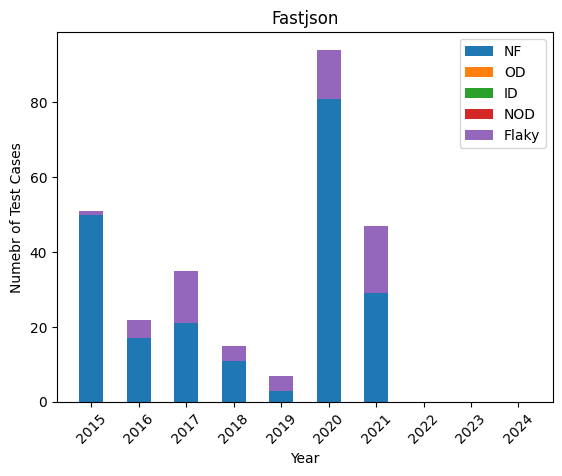

In [268]:

x = list(range(1,number_of_years))

NF_count = []
OD_count = []
ID_count = []
NOD_count = []
Flaky_count = []
for i in x:
    NF_count.append(df_single[df_single['category']=='NF']['bar'].value_counts()[i])
    OD_count.append(df_single[df_single['category']=='OD']['bar'].value_counts()[i])
    ID_count.append(df_single[df_single['category']=='ID']['bar'].value_counts()[i])
    NOD_count.append(df_single[df_single['category']=='NOD']['bar'].value_counts()[i])
    Flaky_count.append(df_single[df_single['category']=='Flaky']['bar'].value_counts()[i])


method_counts = {
    
    'NF': np.array(NF_count),
    'OD': np.array(OD_count),
    'ID': np.array(ID_count),
    'NOD': np.array(NOD_count),
    'Flaky': np.array(Flaky_count)
}

width = 0.5

fig, ax = plt.subplots()

bottom = np.zeros(number_of_years-1)

for boolean, method_count in method_counts.items():
    p = ax.bar(x, method_count, width, label=boolean, bottom=bottom)
    bottom += method_count


ax.set_title("Fastjson")
ax.legend(loc="upper right")

plt.xticks(x,labels=x_labels,rotation = 45)
plt.ylabel("Numebr of Test Cases")
plt.xlabel("Year")

plt.show()

In [376]:
time.gmtime(df_single_chronicle['create_time'].iloc[len(x)//2-50])

time.struct_time(tm_year=2020, tm_mon=1, tm_mday=3, tm_hour=13, tm_min=38, tm_sec=14, tm_wday=4, tm_yday=3, tm_isdst=0)

In [45]:
#df_early = df_single[df_single['bar']<=5]
#df_late = df_single[df_single['bar']>5]

df_single_chronicle_early = df_single_chronicle[df_single_chronicle['create_time']<df_single_chronicle['create_time'].median()]
df_single_chronicle_late = df_single_chronicle[df_single_chronicle['create_time']>=df_single_chronicle['create_time'].median()]

df_single_ormlite_early = df_single_ormlite[df_single_ormlite['create_time']<df_single_ormlite['create_time'].median()]
df_single_ormlite_late = df_single_ormlite[df_single_ormlite['create_time']>=df_single_ormlite['create_time'].median()]

df_single_fastjson_early = df_single_fastjson[df_single_fastjson['create_time']<df_single_fastjson['create_time'].median()]
df_single_fastjson_late = df_single_fastjson[df_single_fastjson['create_time']>=df_single_fastjson['create_time'].median()]


In [219]:
list(df_early['test_case'])[0]

'net.openhft.chronicle.wire.BinaryInTextTest#testReserialize'

In [318]:
print(len(df_single_fastjson_early),len(df_single_fastjson_late))

93 93


In [210]:

file = open("test_cases.txt","w")
for full_name in df_single['id']:
    test_suite = full_name.split(':')[1].rsplit('.',1)[0]
    test_case = full_name.split(':')[1].rsplit('.',1)[1]
    
    output_name = test_suite + '#' + test_case
    file.write(output_name+'\n')

file.close()

In [29]:
with open(r"pkl_chronicle.pickle", "rb") as input_file:
    coverage_data_chronicle= pickle.load(input_file)
with open(r"pkl_ormlite.pickle", "rb") as input_file:
    coverage_data_ormlite= pickle.load(input_file)
with open(r"pkl_fastjson.pickle", "rb") as input_file:
    coverage_data_fastjson= pickle.load(input_file)

In [30]:
def getOutputByCategory(test_keys, df_single):
    output_by_category = dict()
    output_by_category['ID'] = []
    output_by_category['OD'] = []
    output_by_category['NOD'] = []
    output_by_category['Flaky'] = []

    for test in list(test_keys):
        if df_single.category[df_single.test_case.isin([test])].values[0] == 'ID':
            output_by_category['ID'].append(1)
            output_by_category['OD'].append(0)
            output_by_category['NOD'].append(0)
            output_by_category['Flaky'].append(0)
        elif df_single.category[df_single.test_case.isin([test])].values[0] == 'OD':
            output_by_category['ID'].append(0)
            output_by_category['OD'].append(1)
            output_by_category['NOD'].append(0)
            output_by_category['Flaky'].append(0)
        elif df_single.category[df_single.test_case.isin([test])].values[0] == 'NOD':
            output_by_category['ID'].append(0)
            output_by_category['OD'].append(0)
            output_by_category['NOD'].append(1)
            output_by_category['Flaky'].append(0)
        elif df_single.category[df_single.test_case.isin([test])].values[0] == 'Flaky':
            output_by_category['ID'].append(0)
            output_by_category['OD'].append(0)
            output_by_category['NOD'].append(0)
            output_by_category['Flaky'].append(1)
        else:
            output_by_category['ID'].append(0)
            output_by_category['OD'].append(0)
            output_by_category['NOD'].append(0)
            output_by_category['Flaky'].append(0)
    return output_by_category

In [31]:
def getMIScoreDict(coverage_data, df_early, df_late, df_single):
    test_keys = coverage_data.keys()

    test_keys_early = list(df_early['test_case'])
    test_keys_late = list(df_late['test_case'])
    test_keys_total = list(df_single['test_case'])

    method_keys = coverage_data[list(test_keys)[0]].keys()

    output_early = getOutputByCategory(test_keys_early, df_early)
    output_late = getOutputByCategory(test_keys_late, df_late)
    output_total = getOutputByCategory(test_keys_total, df_single)

    invalid_test = [
        'net.openhft.chronicle.wire.IntConversionTest#unsigned',
        'net.openhft.chronicle.wire.IntConversionTest#dto',
        'net.openhft.chronicle.wire.IntConversionTest#method',
        'net.openhft.chronicle.wire.IntConversionTest#twoArgumentsConversion',
        'com.alibaba.json.bvt.parser.TypeUtilsTest#test_cast_to_Timestamp_error'
    ]

    rotate_coverage_early = dict().fromkeys(method_keys)
    rotate_coverage_late = dict().fromkeys(method_keys)
    rotate_coverage_total = dict().fromkeys(method_keys)

    for method in method_keys:
        rotate_coverage_early[method] = dict.fromkeys(df_early['test_case'])
        rotate_coverage_late[method] = dict.fromkeys(df_late['test_case'])
        rotate_coverage_total[method] = dict.fromkeys(df_single['test_case'])

    for method in method_keys:
        for test in test_keys_early:
            if test in invalid_test:
                rotate_coverage_early[method][test] = 0
            else:
                rotate_coverage_early[method][test] = coverage_data[test][method]
        for test in test_keys_late:
            if test in invalid_test:
                rotate_coverage_late[method][test] = 0
            else:
                rotate_coverage_late[method][test] = coverage_data[test][method]
        for test in test_keys_total:
            if test in invalid_test:
                rotate_coverage_total[method][test] = 0
            else:
                rotate_coverage_total[method][test] = coverage_data[test][method]

    mi_dict_early = dict()
    mi_dict_late = dict()
    mi_dict_total = dict()

    for category in df_single['category'].value_counts().keys():
        if category == 'NF':
            continue
        mi_dict_early[category] = dict.fromkeys(method_keys)
        mi_dict_late[category] = dict.fromkeys(method_keys)
        mi_dict_total[category] = dict.fromkeys(method_keys)
        for method in list(method_keys):
            mi_dict_early[category][method] = normalized_mutual_info_score(list(rotate_coverage_early[method].values()),output_early[category])
            mi_dict_late[category][method] = normalized_mutual_info_score(list(rotate_coverage_late[method].values()),output_late[category])
            mi_dict_total[category][method] = normalized_mutual_info_score(list(rotate_coverage_total[method].values()),output_total[category])
    return mi_dict_early, mi_dict_late, mi_dict_total

In [46]:
mi_dict_chronicle_early, mi_dict_chronicle_late, mi_dict_chronicle_total = getMIScoreDict(coverage_data_chronicle, df_single_chronicle_early, df_single_chronicle_late, df_single_chronicle)
mi_dict_ormlite_early, mi_dict_ormlite_late, mi_dict_ormlite_total = getMIScoreDict(coverage_data_ormlite, df_single_ormlite_early, df_single_ormlite_late, df_single_ormlite)
mi_dict_fastjson_early, mi_dict_fastjson_late, mi_dict_fastjson_total = getMIScoreDict(coverage_data_fastjson, df_single_fastjson_early, df_single_fastjson_late, df_single_fastjson)

In [380]:
category = 'ID'
mi_list_early = []
mi_list_late = []
for key in mi_dict_chronicle_early[category]:
    mi_list_early.append(mi_dict_chronicle_early[category][key])
    mi_list_late.append(mi_dict_chronicle_late[category][key])
print(stats.spearmanr(mi_list_early,mi_list_late))

SignificanceResult(statistic=0.6991339917541759, pvalue=0.0)


In [391]:
category = 'ID'
#number = len(mi_dict_fastjson_total[category])
number = 10
sum = 0
mi_list = []
for key in sorted(mi_dict_fastjson_total[category], key=mi_dict_fastjson_total[category].get, reverse=True)[:number]:
    
    #mi_list.append(mi_dict_fastjson_total[category][key])
    sum = sum + mi_dict_fastjson_total[category][key]
print(sum/number)

0.32860219154929765


In [33]:
def getMIComparisonData(number, category, mi_dict_early, mi_dict_late):
    x_method = []
    x_mi_early = []
    x_mi_late = []

    for key in sorted(mi_dict_early[category], key=mi_dict_early[category].get, reverse=True)[:number]:
        method_field = key.rsplit('.',2)[1]
        if len(method_field) > 1:
            method_field = method_field[:1] + "."
        method_name = key.rsplit('.',1)[1]
        if len(method_name) > 8:
            method_name = method_name[:8] + "..."

        x_method.append(method_field+method_name)
        x_mi_early.append(mi_dict_early[category][key])
        x_mi_late.append(mi_dict_late[category][key])
    
    return x_method, x_mi_early, x_mi_late

In [47]:
numebr = 10
#x_OD_method, x_OD_mi_early, x_OD_mi_late = getMIComparisonData(numebr, 'OD', mi_dict_early, mi_dict_late)
#x_ID_method, x_ID_mi_early, x_ID_mi_late = getMIComparisonData(numebr, 'ID', mi_dict_early, mi_dict_late)
#x_NOD_method, x_NOD_mi_early, x_NOD_mi_late = getMIComparisonData(numebr, 'NOD', mi_dict_early, mi_dict_late)
x_chronicle_method, x_chronicle_mi_early, x_chronicle_mi_late = getMIComparisonData(numebr, 'Flaky', mi_dict_chronicle_early, mi_dict_chronicle_late)
x_ormlite_method, x_ormlite_mi_early, x_ormlite_mi_late = getMIComparisonData(numebr, 'Flaky', mi_dict_ormlite_early, mi_dict_ormlite_late)
x_fastjson_method, x_fastjson_mi_early, x_fastjson_mi_late = getMIComparisonData(numebr, 'Flaky', mi_dict_fastjson_early, mi_dict_fastjson_late)

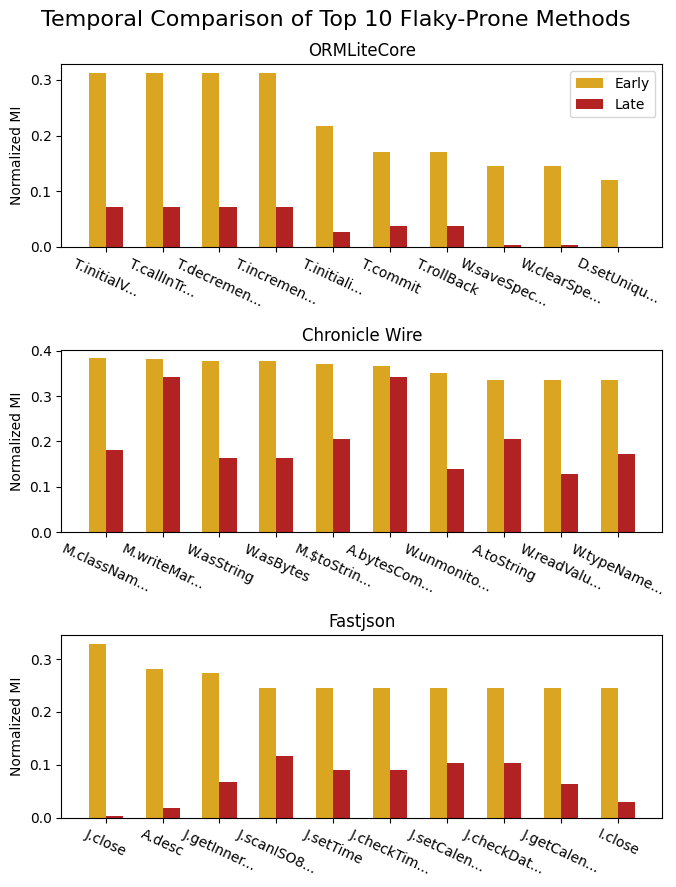

In [48]:
#X_OD_axis = np.arange(len(x_OD_method)) 
#X_ID_axis = np.arange(len(x_ID_method)) 
#X_NOD_axis = np.arange(len(x_NOD_method)) 
X_chronicle_axis = np.arange(len(x_chronicle_method)) 
X_ormlite_axis = np.arange(len(x_ormlite_method)) 
X_fastjson_axis = np.arange(len(x_fastjson_method)) 

fig, axs = plt.subplots(3)
fig.suptitle('Temporal Comparison of Top 10 Flaky-Prone Methods',size = 16)

bar_width = 0.3

axs[0].bar(X_ormlite_axis - bar_width/2, x_ormlite_mi_early, bar_width, label = 'Early', color='goldenrod') 
axs[0].bar(X_ormlite_axis + bar_width/2, x_ormlite_mi_late, bar_width, label = 'Late', color='firebrick') 
axs[0].set_title("ORMLite Core")
axs[0].legend()
axs[0].set_ylabel("Normalized MI")
axs[0].set_xticks(range(len(x_ormlite_method)), labels=x_ormlite_method, rotation = -25)

axs[1].bar(X_chronicle_axis - bar_width/2, x_chronicle_mi_early, bar_width, label = 'Early', color='goldenrod') 
axs[1].bar(X_chronicle_axis + bar_width/2, x_chronicle_mi_late, bar_width, label = 'Late', color='firebrick') 
axs[1].set_title("Chronicle Wire")
axs[1].set_ylabel("Normalized MI")
axs[1].set_xticks(range(len(x_chronicle_method)), labels=x_chronicle_method, rotation = -25)

axs[2].bar(X_fastjson_axis - bar_width/2, x_fastjson_mi_early, bar_width, label = 'Early', color='goldenrod') 
axs[2].bar(X_fastjson_axis + bar_width/2, x_fastjson_mi_late, bar_width, label = 'Late', color='firebrick') 
axs[2].set_title("Fastjson")
axs[2].set_ylabel("Normalized MI")
axs[2].set_xticks(range(len(x_fastjson_method)), labels=x_fastjson_method, rotation = -25)
  
fig.set_size_inches(7,9)
fig.tight_layout()

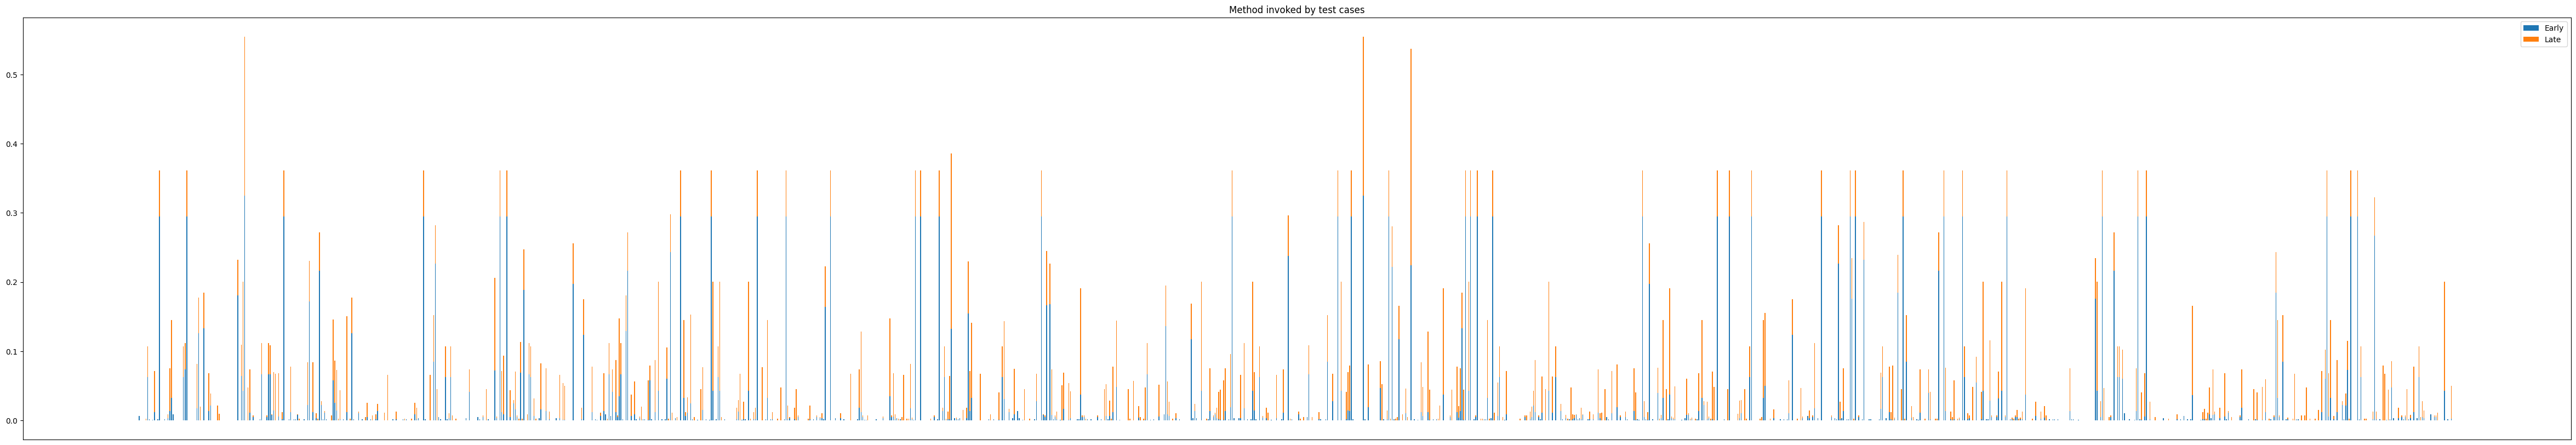

In [53]:
method_counts = {
    
    'Early': np.array(list(mi_dict_early['OD'].values())),
    'Late': np.array(list(mi_dict_late['OD'].values()))
}

width = 0.5

fig, ax = plt.subplots()
fig.set_size_inches(60,10)
bottom = np.zeros(1361)

for boolean, method_count in method_counts.items():
    p = ax.bar(list(mi_dict_late['OD'].keys()), method_count, width, label=boolean, bottom=bottom)
    bottom += method_count


ax.set_title("Method invoked by test cases")
ax.legend(loc="upper right")
plt.xticks([])
plt.show()

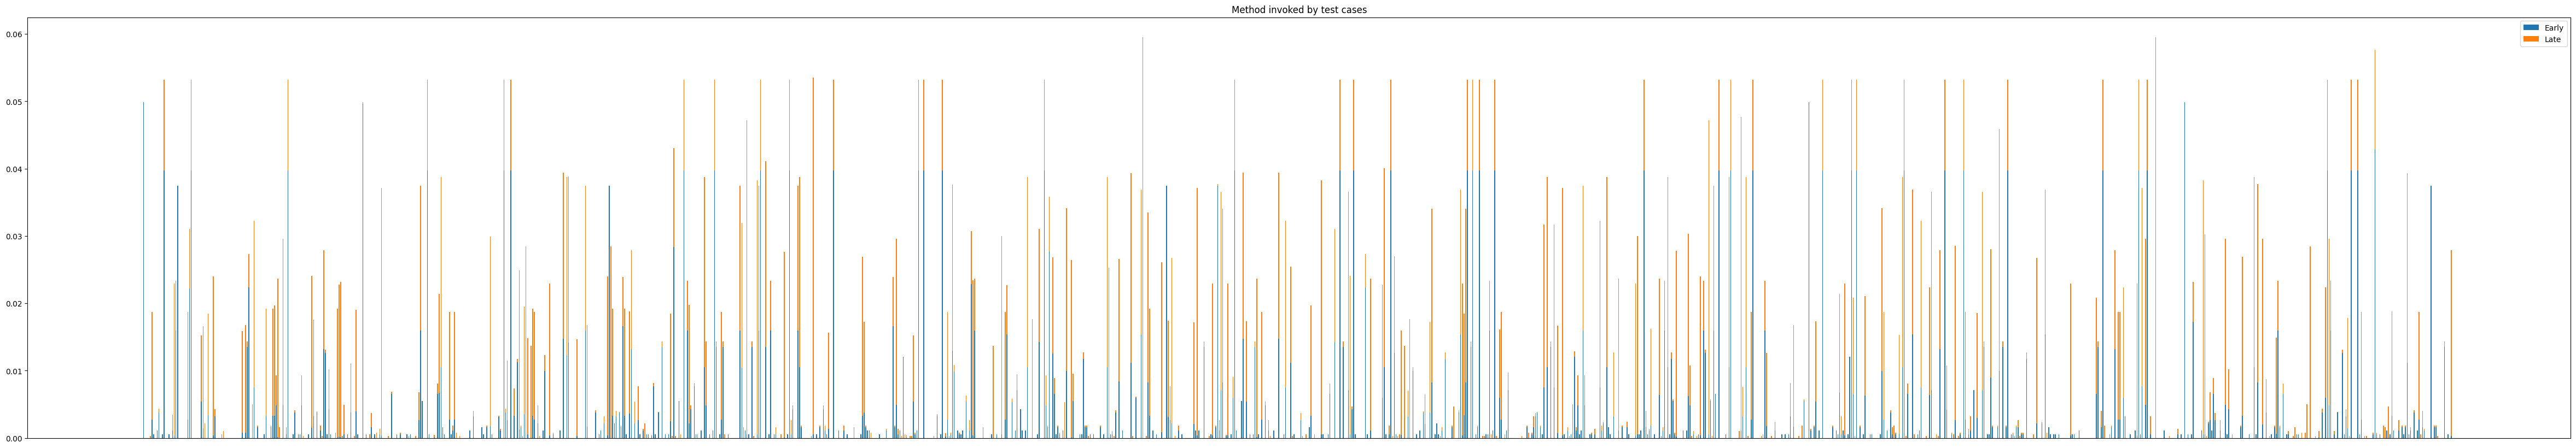

In [54]:
method_counts = {
    
    'Early': np.array(list(mi_dict_early['ID'].values())),
    'Late': np.array(list(mi_dict_late['ID'].values()))
}

width = 0.5

fig, ax = plt.subplots()
fig.set_size_inches(60,10)
bottom = np.zeros(1361)

for boolean, method_count in method_counts.items():
    p = ax.bar(list(mi_dict_late['ID'].keys()), method_count, width, label=boolean, bottom=bottom)
    bottom += method_count


ax.set_title("Method invoked by test cases")
ax.legend(loc="upper right")
plt.xticks([])
plt.show()

In [136]:
mi_sum = dict.fromkeys(method_keys)

for method in method_keys:
    mi_sum[method] = 0
    for category in mi_dict:
        mi_sum[method] = mi_sum[method] + mi_dict[category][method]

sorted_mi_keys = {k: v for k, v in sorted(mi_sum.items(), key=lambda item: item[1], reverse=True)}.keys()

In [137]:
sorted_mi = dict()

for category in mi_dict:
    if category == 'NF':
        continue
    sorted_mi[category] = dict.fromkeys(sorted_mi_keys)
    for test in sorted_mi[category]:
        sorted_mi[category][test] = 0

for category in mi_dict:
    for method in mi_dict[category]:
        sorted_mi[category][method] = mi_dict[category][method]

In [138]:
{k: v for k, v in sorted(mi_dict['ID'].items(), key=lambda item: item[1], reverse=True)}

{'com.alibaba.fastjson.serializer.JSONSerializer.containsReference': 0.23986333002825286,
 'com.alibaba.fastjson.serializer.SerializeWriter.writeFieldName': 0.22586271037016042,
 'com.alibaba.fastjson.serializer.MapSerializer.write': 0.22586271037016042,
 'com.alibaba.fastjson.serializer.JSONSerializer.incrementIndent': 0.21927520161976605,
 'com.alibaba.fastjson.serializer.JSONSerializer.decrementIdent': 0.21927520161976605,
 'com.alibaba.fastjson.serializer.SerializerFeature.of': 0.1828144134779121,
 'com.alibaba.fastjson.serializer.SerializeFilterable.processValue': 0.15248497131888655,
 'com.alibaba.fastjson.serializer.SerializerFeature.isEnabled': 0.15248497131888655,
 'com.alibaba.fastjson.util.ServiceLoader.load': 0.1330334770346476,
 'com.alibaba.fastjson.serializer.SerializeWriter.close': 0.1330334770346476,
 'com.alibaba.fastjson.util.IOUtils.close': 0.13010290410834188,
 'com.alibaba.fastjson.serializer.SerializeConfig.getObjectWriter': 0.12158892970167089,
 'com.alibaba.fas

In [14]:
print(df_single.category[df_single.test_case.isin(['net.openhft.chronicle.wire.YamlWireTest#testYNestedList'])].values[0])

ID


In [126]:
method_reachability_count = dict()

for k in df_single['category'].value_counts().keys():
    method_reachability_count[k] = dict.fromkeys(method_keys)

for category in method_reachability_count:
    for test in method_reachability_count[category]:
        method_reachability_count[category][test] = 0

for test in coverage_data:
    category = df_single.category[df_single.test_case.isin([test])].values[0]
    for method in coverage_data[test]:
        method_reachability_count[category][method] = method_reachability_count[category][method] + coverage_data[test][method]
        

In [127]:
method_reachability_count_sum = dict.fromkeys(method_keys)

for method in method_keys:
    method_reachability_count_sum[method] = 0
    for category in method_reachability_count:
        method_reachability_count_sum[method] = method_reachability_count_sum[method] + method_reachability_count[category][method]

sorted_method_keys = {k: v for k, v in sorted(method_reachability_count_sum.items(), key=lambda item: item[1], reverse=True)}.keys()

In [128]:
sorted_method_reachability_count = dict()

for k in df_single['category'].value_counts().keys():
    sorted_method_reachability_count[k] = dict.fromkeys(sorted_method_keys)

for category in sorted_method_reachability_count:
    for test in sorted_method_reachability_count[category]:
        sorted_method_reachability_count[category][test] = 0

for test in coverage_data:
    category = df_single.category[df_single.test_case.isin([test])].values[0]
    for method in coverage_data[test]:
        sorted_method_reachability_count[category][method] = sorted_method_reachability_count[category][method] + coverage_data[test][method]

In [33]:
mixed_methods = []
for method in method_reachability_count['NF']:
    all_NF = True
    NF_count = method_reachability_count['NF'][method]
    for c in df_single['category'].value_counts().keys():
        if c == 'NF':
            continue
        if NF_count > 0 and method_reachability_count[c][method] > 0:
            all_NF = False
    if not all_NF:
        mixed_methods.append(method)
        
for method in mixed_methods:
    for c in df_single['category'].value_counts().keys():
        method_reachability_count[c].pop(method, None)

meaningful_method_keys = method_reachability_count['NF'].keys()

In [108]:
{k: v for k, v in sorted(method_reachability_count['OD'].items(), key=lambda item: item[1], reverse=True)}

{'com.j256.ormlite.logger.LoggerFactory.chooseDefaultBackendFactory': 87,
 'com.j256.ormlite.logger.backend.LogbackLogBackend$LogbackLogBackendFactory.createLogBackend': 87,
 'com.j256.ormlite.logger.backend.Log4j2LogBackend$Log4j2LogBackendFactory.isAvailable': 87,
 'com.j256.ormlite.dao.DaoManager.clearCache': 87,
 'com.j256.ormlite.db.BaseDatabaseType.setDriver': 87,
 'com.j256.ormlite.logger.backend.Slf4jLoggingLogBackend$Slf4jLoggingLogBackendFactory.isAvailable': 87,
 'com.j256.ormlite.logger.Level.fromString': 87,
 'com.j256.ormlite.logger.PropertyUtils.readDiscoveryOrderProperty': 87,
 'com.j256.ormlite.logger.PropertyUtils.readLocalLogPatterns': 87,
 'com.j256.ormlite.logger.PropertyUtils.readBackendTypeClassProperty': 87,
 'com.j256.ormlite.logger.backend.JavaUtilLogBackend$JavaUtilLogBackendFactory.isAvailable': 87,
 'com.j256.ormlite.logger.LoggerFactory.getLogger': 87,
 'com.j256.ormlite.dao.DaoManager.clearDaoCache': 87,
 'com.j256.ormlite.logger.PropertyUtils.getProperti

In [35]:
test_with_pure_method = dict()
for k in df_single['category'].value_counts().keys():
    test_with_pure_method[k] = 0

for test in coverage_data:
    caused_by_pure_method = False
    for method in coverage_data[test]:
        if method not in mixed_methods:
            caused_by_pure_method = True

    if caused_by_pure_method:
        category = df_single.category[df_single.test_case.isin([test])].values[0]
        test_with_pure_method[category] = test_with_pure_method[category] + 1



In [129]:
df_single['category'].value_counts()

category
NF     123
ID      43
OD      16
NOD      4
Name: count, dtype: int64

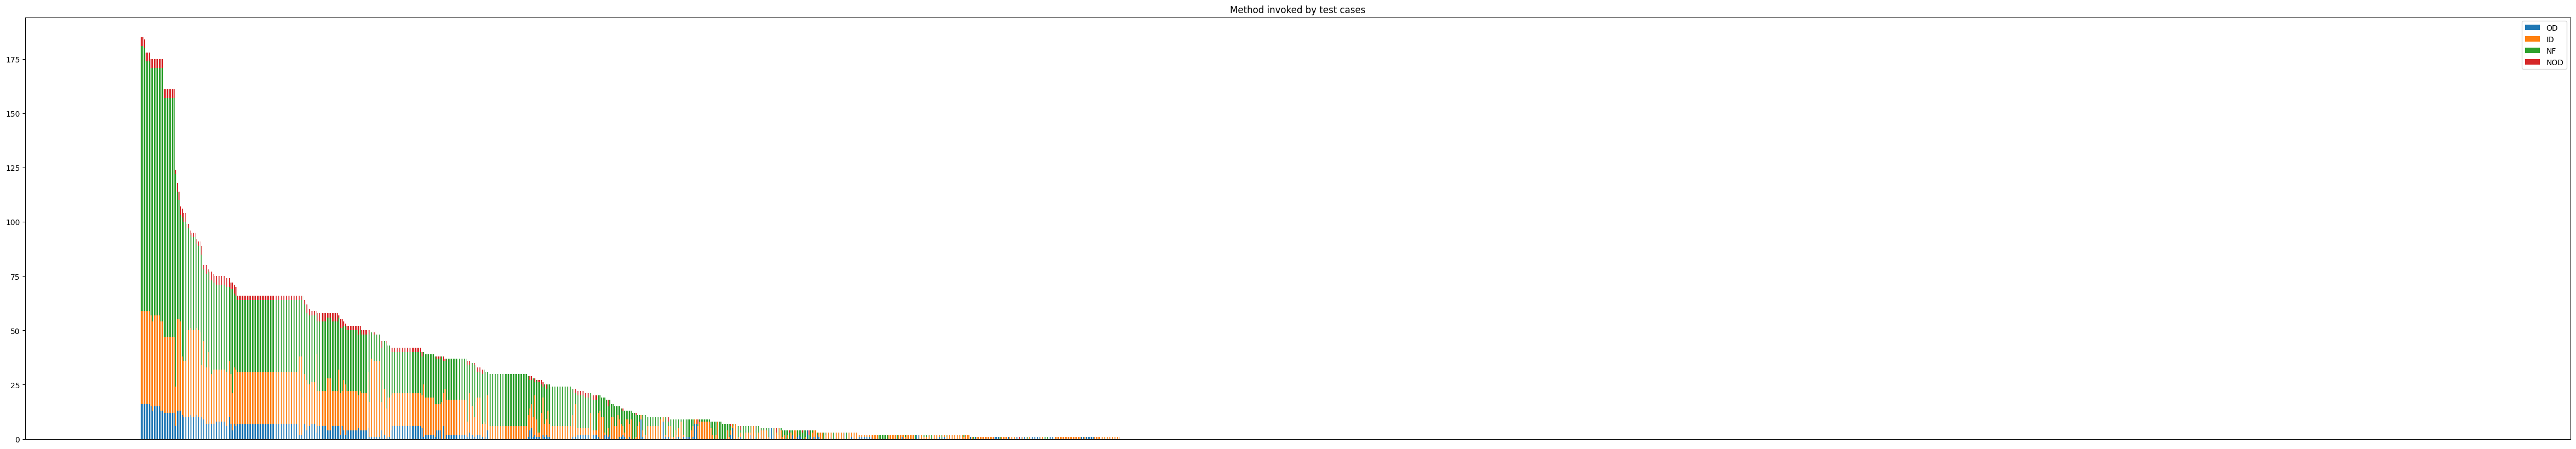

In [131]:
NF_count = list(sorted_method_reachability_count['NF'].values())
OD_count = list(sorted_method_reachability_count['OD'].values())
ID_count = list(sorted_method_reachability_count['ID'].values())
NOD_count = list(sorted_method_reachability_count['NOD'].values())

method_counts = {
    
    'OD': np.array(OD_count),
    'ID': np.array(ID_count),
    'NF': np.array(NF_count),
    'NOD': np.array(NOD_count)
}

width = 0.5

fig, ax = plt.subplots()
fig.set_size_inches(60,10)
bottom = np.zeros(1418)

for boolean, method_count in method_counts.items():
    p = ax.bar(list(sorted_method_keys), method_count, width, label=boolean, bottom=bottom)
    bottom += method_count


ax.set_title("Method invoked by test cases")
ax.legend(loc="upper right")
plt.xticks([])
plt.show()

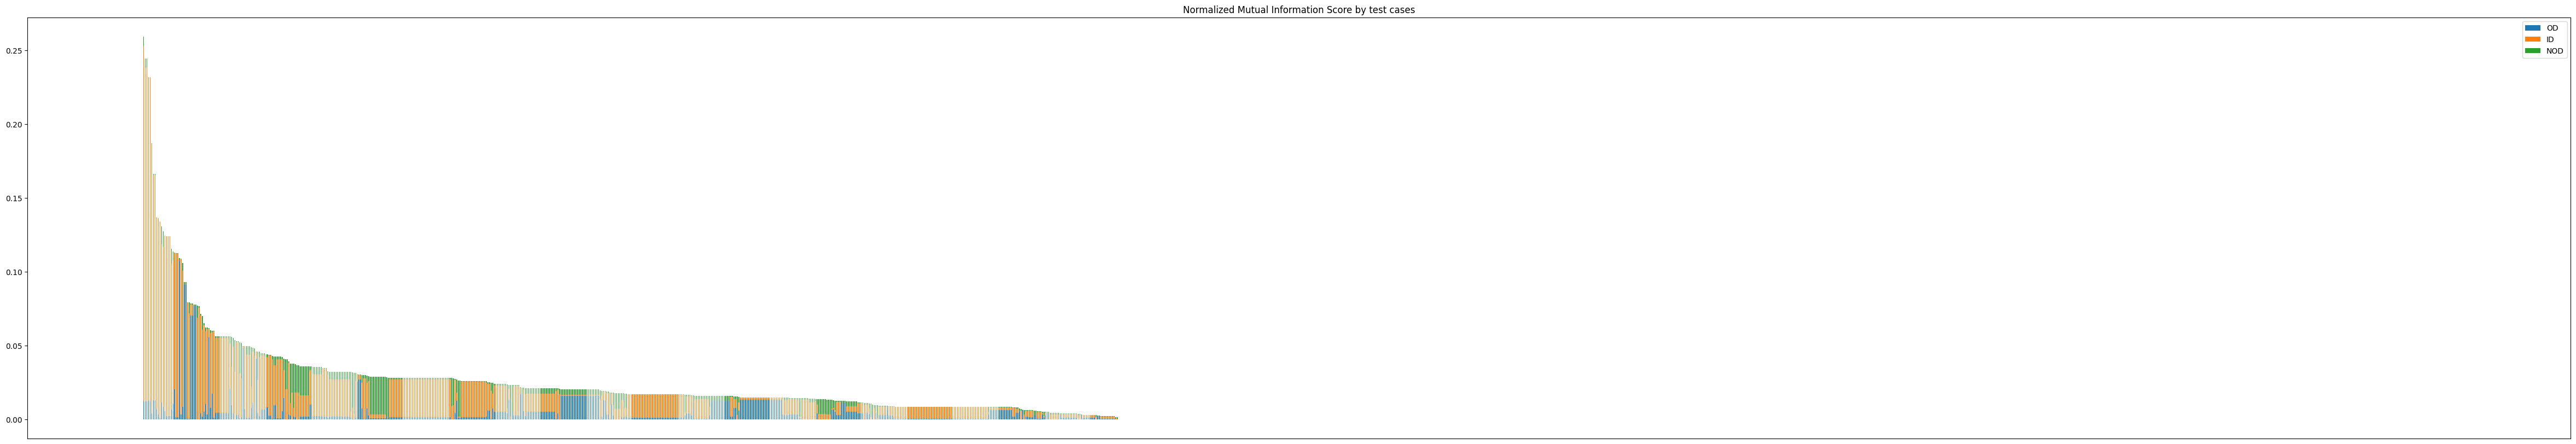

In [139]:
OD_mi_values = list(sorted_mi['OD'].values())
ID_mi_values = list(sorted_mi['ID'].values())
NOD_mi_values = list(sorted_mi['NOD'].values())

mi_values = {
    'OD': np.array(OD_mi_values),
    'ID': np.array(ID_mi_values),
    'NOD': np.array(NOD_mi_values)
}

width = 0.5

fig, ax = plt.subplots()
fig.set_size_inches(60,10)
bottom = np.zeros(1418)

for boolean, mi_value in mi_values.items():
    p = ax.bar(list(sorted_mi_keys), mi_value, width, label=boolean, bottom=bottom)
    bottom += mi_value


ax.set_title("Normalized Mutual Information Score by test cases")
ax.legend(loc="upper right")
plt.xticks([])
plt.show()

In [27]:
coverage_embedding = []
for test in coverage_data:
    single_coverage = []
    for method in coverage_data[test]:
        single_coverage.append(coverage_data[test][method])
    coverage_embedding.append(single_coverage)
df_single['coverage']=coverage_embedding

ValueError: Length of values (185) does not match length of index (186)

In [42]:
df_NF = df_single[df_single['category'].isin(['NF'])]

In [14]:
df_single.head(1)

,id,project_url,raw,category,is_flaky,project,test_case,coverage
9650,ormlite-core:com.j256.ormlite.dao.RuntimeExcep...,https://github.com/j256/ormlite-core,@Test ( expected = RuntimeException . class ) ...,OD,True,ormlite-core,com.j256.ormlite.dao.RuntimeExceptionDaoTest#t...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [15]:
dummpy = np.array([[1,2,3],[3,2,3],[4,2,3]])
print(type(dummpy[0]))

coverage_matrix = np.array([[x for x in y] for y in df_single['coverage']])

<class 'numpy.ndarray'>


In [40]:
df_single['coverage']

9650     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
9651     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9652     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
9653     [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...
9654     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
                               ...                        
10069    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
10071    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10072    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
10073    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
10074    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: coverage, Length: 321, dtype: object

In [17]:
pca = PCA(n_components=2)
reduced_coverage = pca.fit_transform(coverage_matrix)

In [21]:
lda = LinearDiscriminantAnalysis(n_components=2)
reduced_coverage = lda.fit_transform(coverage_matrix,df_single['category'])

In [18]:
def generateScatterPlot(outputDir, outputName, vector, result, categoryName, colors, figSize):
    lw = 2
    plt.figure(figsize=figSize)
    for color, i, category_names in zip(colors, categoryName, categoryName):
        plt.scatter(
            vector[result == i, 0], vector[result == i, 1], color=color, alpha=0.2, lw=lw, label=category_names
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("LDA of ormlite-core")
    return

In [19]:
categoryNames = ['NF', 'ID','OD','NOD']
colors = ["blue", "red", "green", "indigo"]

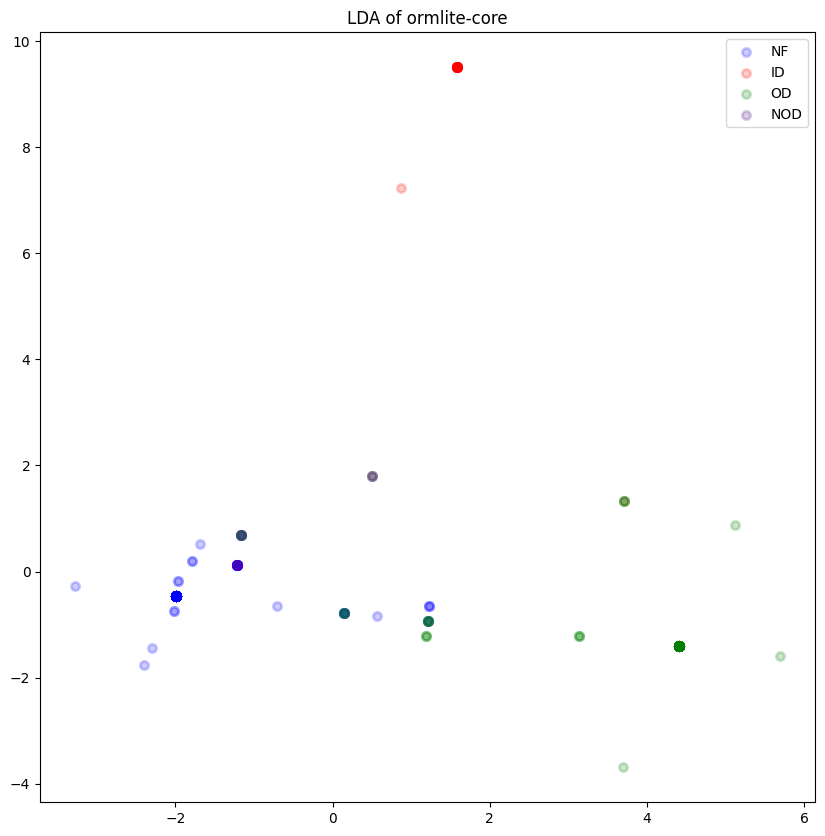

In [22]:
generateScatterPlot(None, None, reduced_coverage, df_single['category'], categoryNames, colors, [10,10])

In [352]:
f = []
for i in range(384):
    f.append('feature_'+str(i))

In [354]:
['f', 'test'] + f

['f',
 'test',
 'feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19',
 'feature_20',
 'feature_21',
 'feature_22',
 'feature_23',
 'feature_24',
 'feature_25',
 'feature_26',
 'feature_27',
 'feature_28',
 'feature_29',
 'feature_30',
 'feature_31',
 'feature_32',
 'feature_33',
 'feature_34',
 'feature_35',
 'feature_36',
 'feature_37',
 'feature_38',
 'feature_39',
 'feature_40',
 'feature_41',
 'feature_42',
 'feature_43',
 'feature_44',
 'feature_45',
 'feature_46',
 'feature_47',
 'feature_48',
 'feature_49',
 'feature_50',
 'feature_51',
 'feature_52',
 'feature_53',
 'feature_54',
 'feature_55',
 'feature_56',
 'feature_57',
 'feature_58',
 'feature_59',
 'feature_60',
 'feature_61',
 'feature_62',
 'feature_63',
 'feature_64',
 'feature_65',
 'fea